In [1]:
# enable autoreload
%load_ext autoreload
%autoreload 2
%matplotlib inline
%reload_ext autoreload

import os
import random

import scvi
scvi.settings.seed = 0
import scanpy as sc
import anndata as ad
import torch
import numpy as np
import pandas as pd
from datetime import datetime
from scipy.sparse import csr_matrix
torch.set_float32_matmul_precision('medium')
import warnings
warnings.simplefilter("ignore", UserWarning)
import matplotlib.pyplot as plt
from matplotlib.pyplot import rc_context
import seaborn as sns

# from scfair.evaluate import *
# from scfair_reproducibility.evaluation.metrics import *

from dis2p_reproducibility.dis2p_defunct import dis2pvi_cE as dvi
import biolord
from scvi.model.base import BaseModelClass

# from dis2p_reproducibility.dis2p_defunct import dis2pvi as dvi

import scib

from sklearn.metrics import r2_score



Global seed set to 0
Global seed set to 0


In [2]:
adata = sc.read_h5ad('eraslan_preprocessed1200_split.h5ad')
adata_biolord = sc.read_h5ad('eraslan_preprocessed1200_split.h5ad')

In [3]:
cats = ['tissue', 'Sample ID', 'Broad cell type', 'sex', 'Age_bin']
# cats = ['tissue', 'Sample ID', 'cell_type', 'sex', 'Age_bin']
pre_path = 'models/dis2p_cE/'
model_name = 'cf20beta1/'
# model_name = 'fine_tuned_regLoss_ood/'
# model_name = 'fine_tuned_regLoss/'
model = dvi.Dis2pVI_cE.load(f"{pre_path}/{model_name}", adata=adata)

INFO     File models/dis2p_cE//ft_custom/model.pt already downloaded                                               


An NVIDIA GPU may be present on this machine, but a CUDA-enabled jaxlib is not installed. Falling back to cpu.


In [4]:
# biolord_model = biolord.Biolord.load('models/biolord/eraslan_ood/', adata=adata_biolord)
biolord_model = biolord.Biolord.load('models/biolord/eraslan_ood_basicSettings/', adata=adata_biolord)

INFO     File models/biolord/eraslan_ood_basicSettings/model.pt already downloaded                                 


Global seed set to 42


In [5]:
biolord_model

Biolord training status: Trained

## scIB Analysis

In [6]:
# Z_0
adata.obsm[f'dis2p_cE_Z_0'] = model.get_latent_representation(nullify_cat_covs_indices=[s for s in range(len(cats))], nullify_shared=False)

for i in range(len(cats)):
    null_idx = [s for s in range(len(cats)) if s != i]
    # Z_i
    adata.obsm[f'dis2p_cE_Z_{i+1}'] = model.get_latent_representation(nullify_cat_covs_indices=null_idx, nullify_shared=True)
    # Z_{-i}
    adata.obsm[f'dis2p_cE_Z_not_{i+1}'] = model.get_latent_representation(nullify_cat_covs_indices=[i], nullify_shared=False)

---UMAP for dis2p_cE_Z_0---


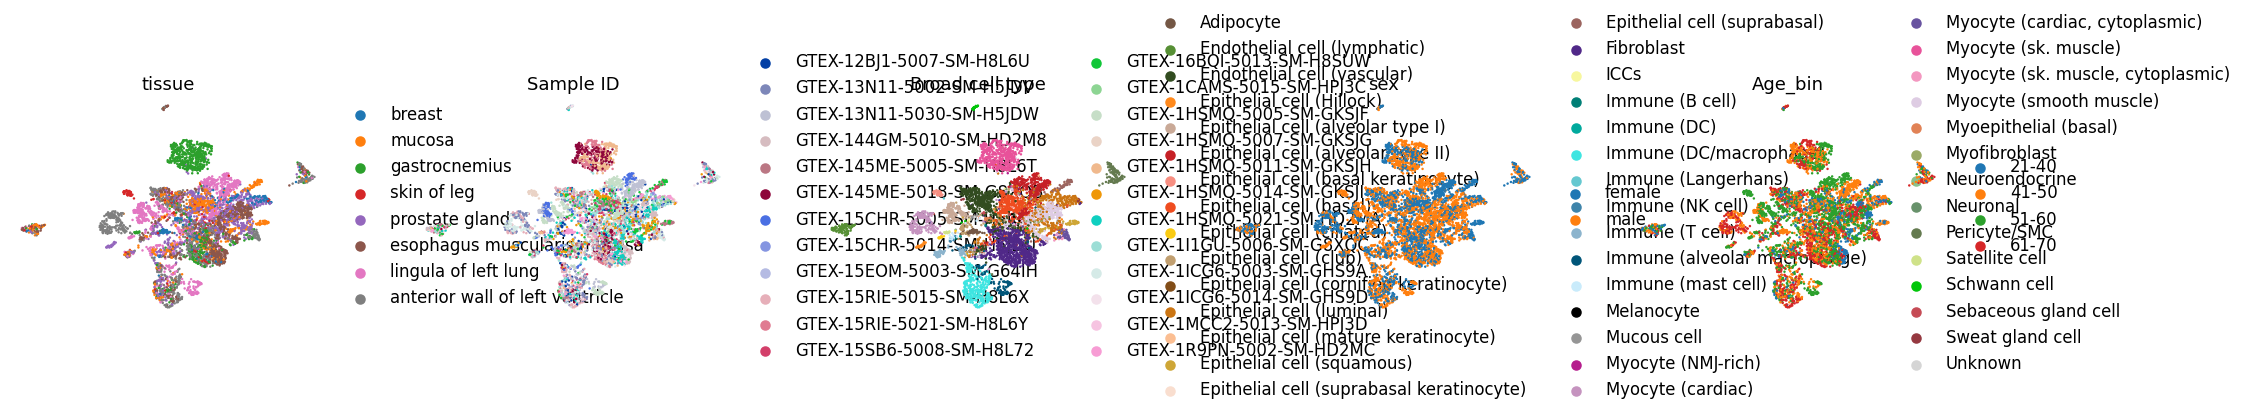

---UMAP for dis2p_cE_Z_1---
tissue


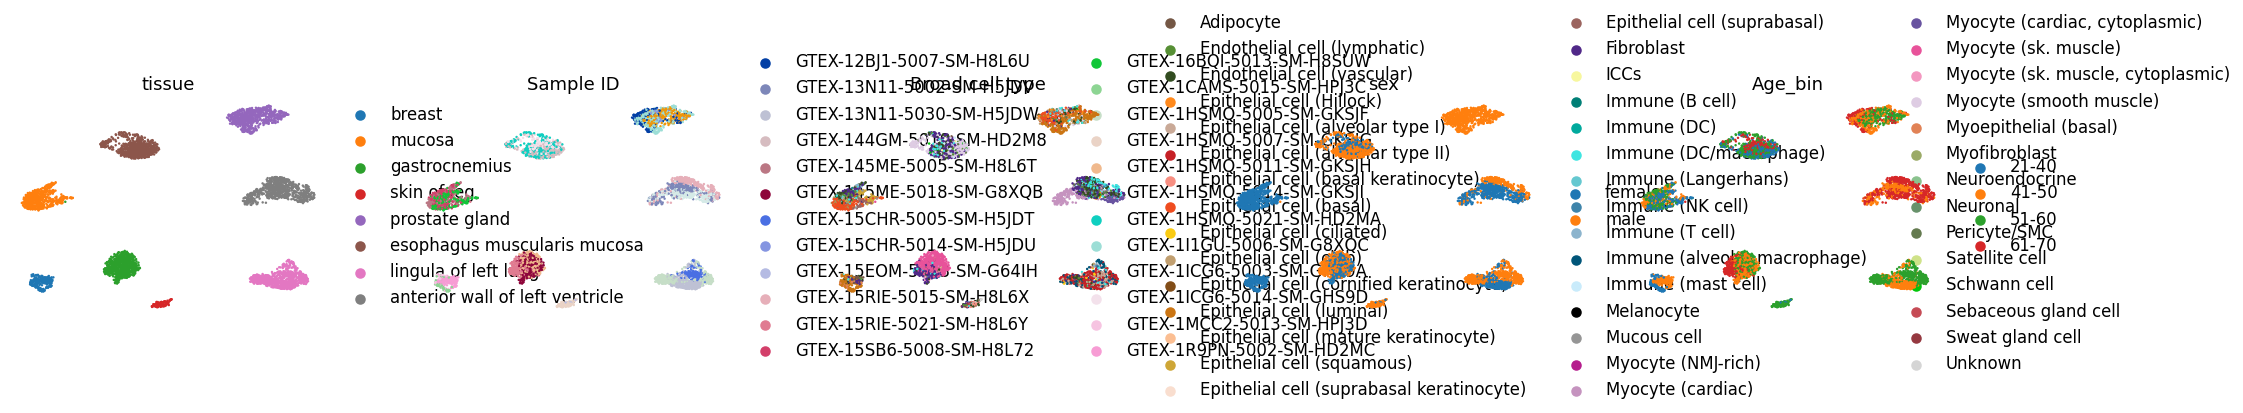

---UMAP for dis2p_cE_Z_2---
Sample ID


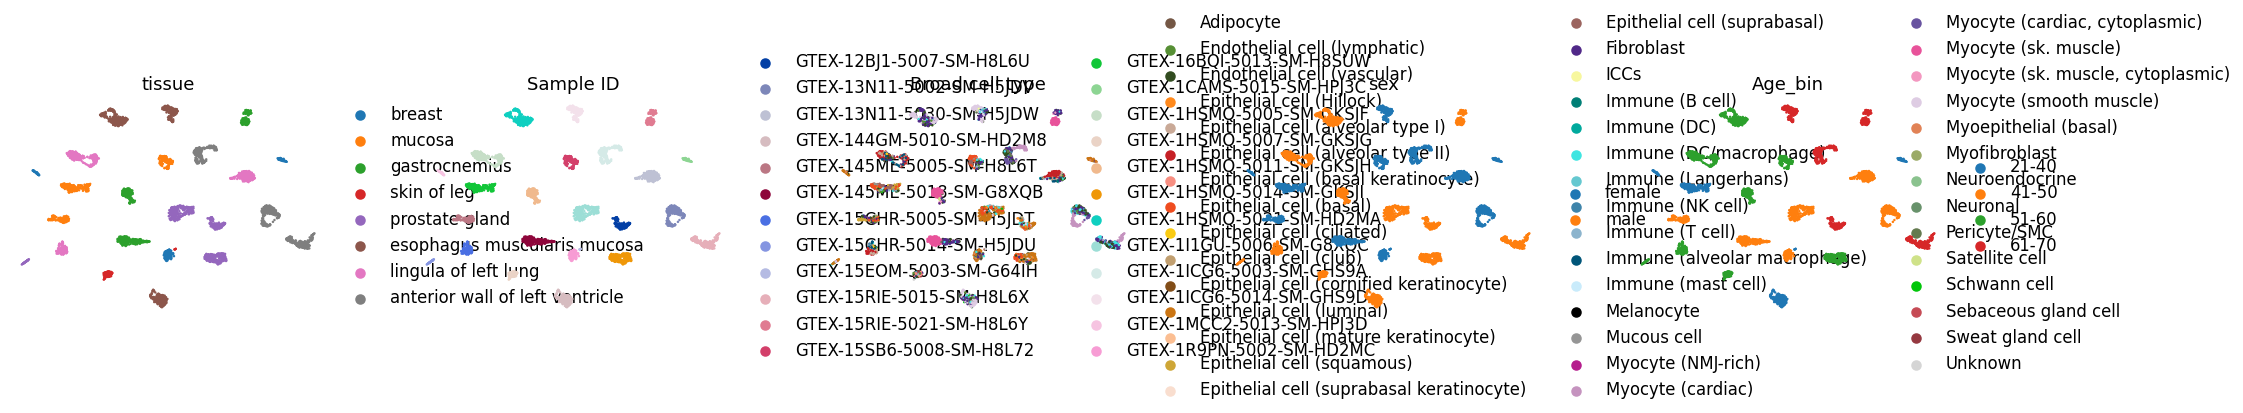

---UMAP for dis2p_cE_Z_3---
Broad cell type


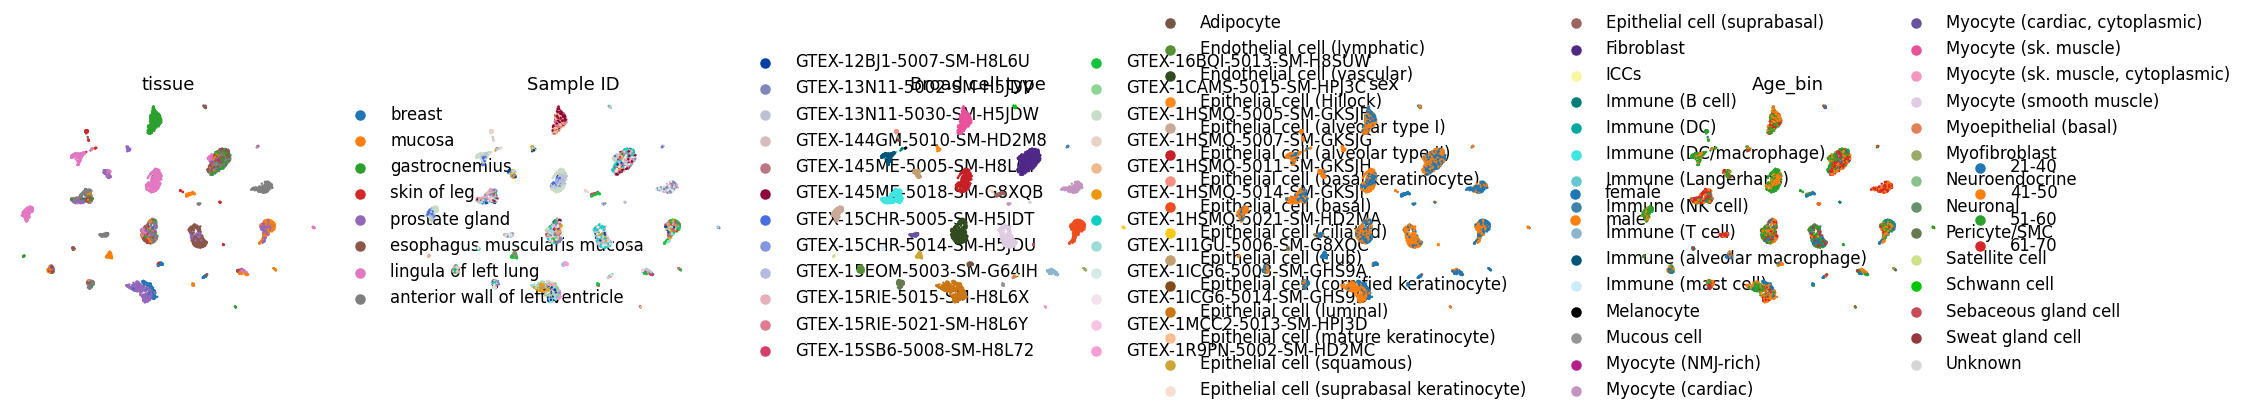

---UMAP for dis2p_cE_Z_4---
sex


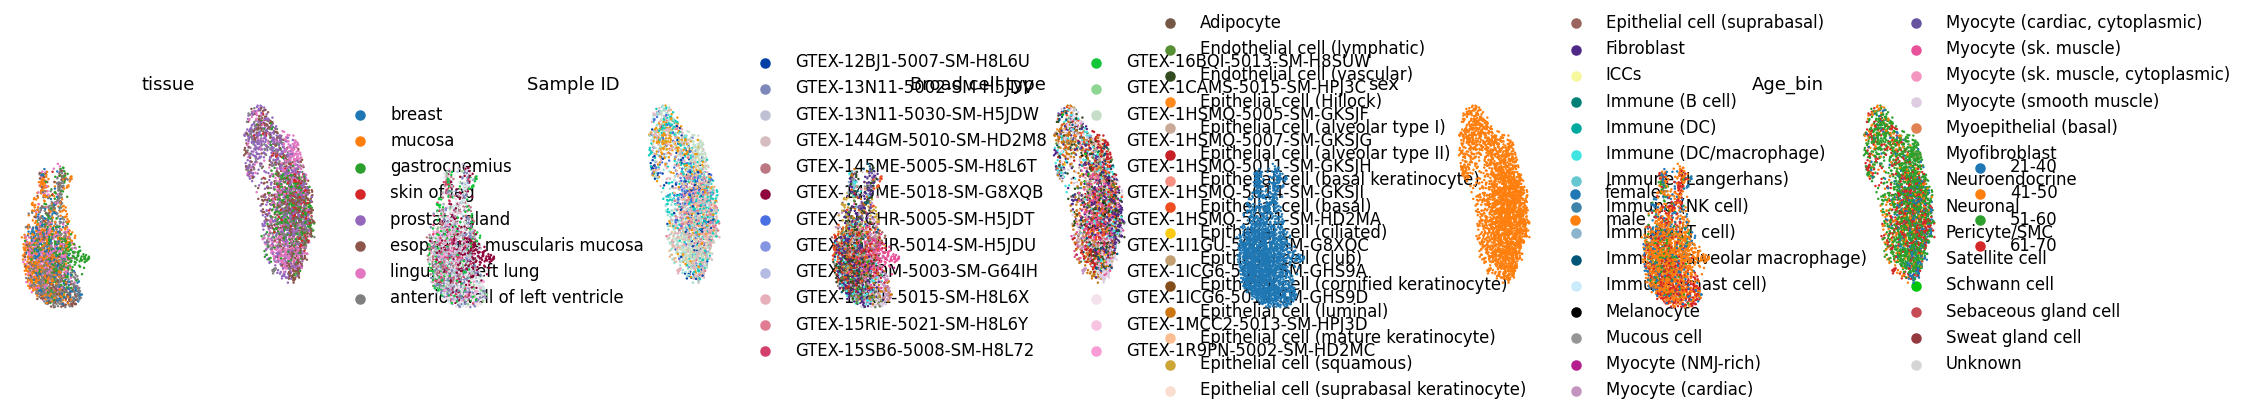

---UMAP for dis2p_cE_Z_5---
Age_bin


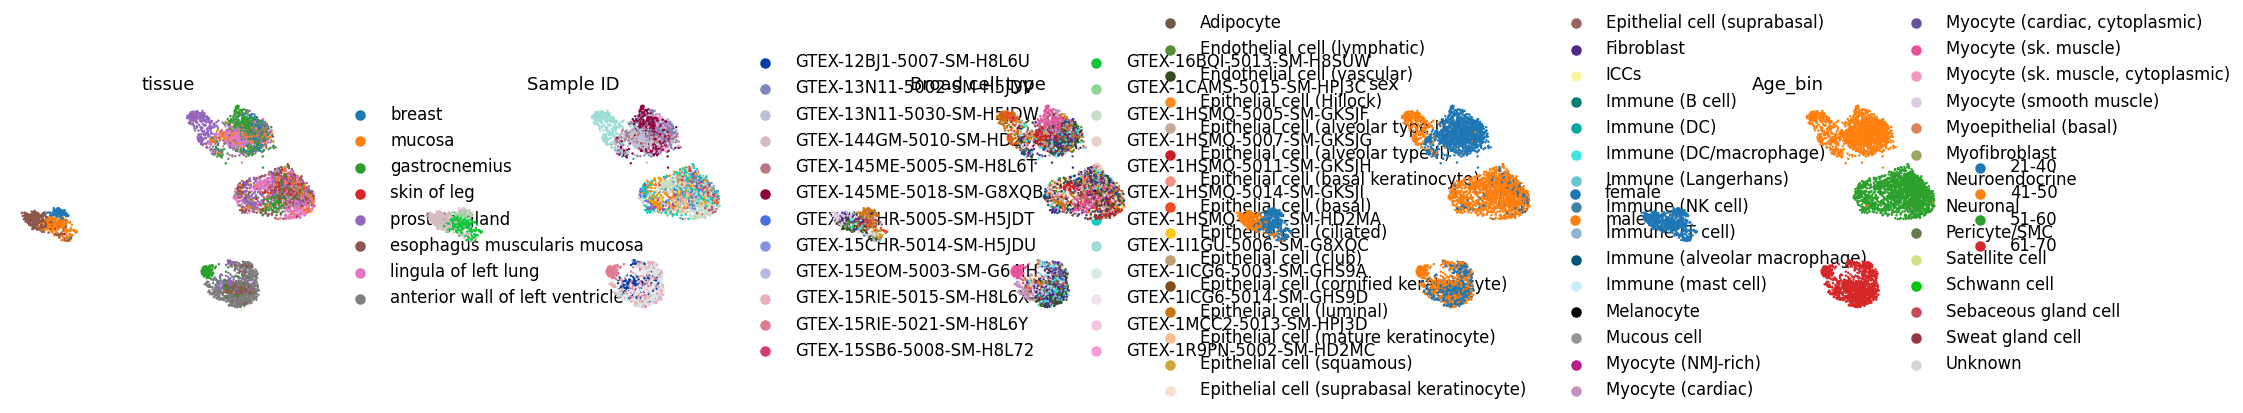

In [7]:
import warnings
warnings.filterwarnings("ignore")
import random
sample = random.sample(range(len(adata)), 5000)

nrow = len(cats) + 1
ncol = len(cats)
# fig, axs = plt.subplots(nrow, ncol, figsize=(2 * ncol, 2 * nrow))

for i in range(len(cats) + 1):  # loop over all Z_i
    latent_name = f'dis2p_cE_Z_{i}'

    print(f"---UMAP for {latent_name}---")
    if i != 0:
        print(cats[i - 1])
    adata_ = adata[sample]
    sc.pp.neighbors(adata_, use_rep=f"{latent_name}")
    sc.tl.umap(adata_)

    sc.pl.umap(
        adata_,
        color=cats,
        ncols=len(cats),
        frameon=False,
        # ax=axs[i][:]
    )

In [8]:
# results = {}
# for i, label in enumerate(cats):
#     for batch in cats:
#         if label == batch:
#             continue
#         results[label][batch] = scib.me.silhouette_batch(adata, batch_key=batch, label_key=label, embed=f"dis2p_cE_Z_{i+1}")

In [9]:
results = {}

for i, label in enumerate(cats):
    results[label] = {}
    results[label]['conservation'] = scib.me.silhouette(adata_, label_key=label, embed=f"dis2p_cE_Z_{i+1}")    
    for batch in cats:
        if label == batch:
            continue
        results[label][f'{batch}_batch'] = scib.me.silhouette(adata_, label_key=batch, embed=f"dis2p_cE_Z_{i+1}")

In [10]:
pd.DataFrame.from_dict(results).T

,conservation,Sample ID_batch,Broad cell type_batch,sex_batch,Age_bin_batch,tissue_batch
tissue,0.625490,0.513673,0.416689,0.504039,0.479237,NaN
Sample ID,0.665031,NaN,0.392273,0.509266,0.493758,0.511933
Broad cell type,0.721986,0.422530,NaN,0.503354,0.493999,0.491448
sex,0.635952,0.472385,0.369985,NaN,0.498633,0.441800
Age_bin,0.580697,0.495801,0.372208,0.510488,NaN,0.442623


## R2 CF Analysis

In [11]:
adata.obs['idx'] = [i for i in range(len(adata))]

true_idx = list(adata[(adata.obs['split'] == 'test') & (adata.obs['sex'] == 'male') & (adata.obs['tissue'] == 'lingula of left lung')].obs.idx)
source_sub_idx = list(adata[(adata.obs['split'] == 'test') & (adata.obs['sex'] == 'female') & (adata.obs['tissue'] == 'lingula of left lung')].obs.idx)
train_sub_idx = list(adata[(adata.obs['split'] == 'train')].obs.idx)

cats = ['tissue', 'Sample ID', 'Broad cell type', 'sex', 'Age_bin']
cov_idx = 3
cov_value = 'female'
cov_value_cf = 'male'

In [12]:
adata_sub = adata[train_sub_idx]
source_adata = adata[source_sub_idx]

adata_sub_biolord = adata_biolord[train_sub_idx]
source_adata_biolord = adata_biolord[source_sub_idx]

In [13]:
from typing import NamedTuple


class _REGISTRY_KEYS_NT(NamedTuple):
    X_KEY: str = "X"
    BATCH_KEY: str = "batch"
    LABELS_KEY: str = "labels"
    PROTEIN_EXP_KEY: str = "proteins"
    CAT_COVS_KEY: str = "extra_categorical_covs"
    CONT_COVS_KEY: str = "extra_continuous_covs"
    INDICES_KEY: str = "ind_x"
    SIZE_FACTOR_KEY: str = "size_factor"
    LATENT_MODE_KEY: str = "latent_mode"
    LATENT_QZM_KEY: str = "latent_qzm"
    LATENT_QZV_KEY: str = "latent_qzv"


REGISTRY_KEYS = _REGISTRY_KEYS_NT()


In [14]:
adata.var['name'] = adata.var.index
# adata_test_tissue = adata[(adata.obs['split'] == 'test') & (adata.obs['tissue'] == 'lingula of left lung')].copy()
sc.tl.rank_genes_groups(
    adata,
    groupby='sex',
    # reference='female',
    rankby_abs=True,
    method='wilcoxon',
    use_raw=False,
    n_genes=200,
    gene_symbols='name',
    # key_added="wilcoxon"
)

In [15]:
deg_list = list(gene[0] for gene in adata.uns['rank_genes_groups']['names'])

In [16]:
adata_cf = source_adata.copy()
cov_name = cats[cov_idx]
adata_cf.obs[cov_name] = pd.Categorical([cov_value_cf for _ in adata_cf.obs[cov_name]])
batch_size=512
device='cuda'
model.setup_anndata(
    adata_cf,
    layer='counts',
    categorical_covariate_keys=cats,
    continuous_covariate_keys=[]
)

adata_cf = model._validate_anndata(adata_cf)

scdl = model._make_data_loader(
    adata=adata_cf, batch_size=batch_size
)

px_cf_mean_list = []

num_samples = 200

i = 0
for tensors in scdl:
    print(i)
    i += 1
    px_cf = model.module.sub_forward(idx=cov_idx + 1, x=tensors[REGISTRY_KEYS.X_KEY].to(device),
                                    cat_covs=tensors[REGISTRY_KEYS.CAT_COVS_KEY].to(device))

    # px_cf_mean_list.append(px_cf.sample())
    # px_cf_mean_list.append(px_cf.mean)
    samples = []
    for j in range(num_samples):
        samples.append(px_cf.sample().to('cpu'))
    samples = torch.stack(samples, dim=0)
    px_cf = torch.mean(samples, dim=0)
    px_cf_mean_list.append(px_cf)

INFO     AnnData object appears to be a copy. Attempting to transfer setup.                                        
0


In [17]:
px_cf_mean_tensor = torch.cat(px_cf_mean_list, dim=0)
px_cf_mean_pred = torch.mean(px_cf_mean_tensor, dim=0)

px_cf_variance = torch.sub(px_cf_mean_tensor, px_cf_mean_pred)
px_cf_variance = torch.pow(px_cf_variance, 2)
px_cf_variance_pred = torch.mean(px_cf_variance, dim=0)

px_cf_mean_pred, px_cf_variance_pred = px_cf_mean_pred.to('cpu'), px_cf_variance_pred.to('cpu')
px_cf_mean_tensor = px_cf_mean_tensor.to('cpu').numpy()

px_cf_mean_tensor = ad.AnnData(px_cf_mean_tensor)

In [18]:
biolord_preds = biolord_model.compute_prediction_adata(adata_biolord, adata_source=source_adata_biolord, target_attributes=['sex'])

INFO     Received view of anndata, making copy.                                                                    
INFO     Input AnnData not setup with scvi-tools. attempting to transfer AnnData setup                             


0it [00:00, ?it/s]

INFO     AnnData object appears to be a copy. Attempting to transfer setup.                                        


1it [00:02,  2.31s/it]

INFO     AnnData object appears to be a copy. Attempting to transfer setup.                                        


2it [00:05,  2.52s/it]


In [19]:
biolord_preds = biolord_preds[biolord_preds.obs['sex'] == 'male']
biolord_preds

View of AnnData object with n_obs × n_vars = 345 × 1200
    obs: 'sex'

In [20]:
biolord_preds_tensor = torch.tensor(biolord_preds.X)

In [21]:
# Random sampling from dataset
adata_for_sample = adata[adata.obs['sex'] == 'male']
sample_ids = random.sample(range(len(adata_for_sample)), num_samples)
sampled_adata = adata_for_sample[sample_ids].copy()

In [22]:
sc.pp.normalize_total(px_cf_mean_tensor)

In [23]:
px_cf_mean_tensor = torch.tensor(px_cf_mean_tensor.X)

In [24]:
source_adata_cf = adata[source_sub_idx].copy()
source_adata_true = adata[true_idx].copy()

true_x_count = torch.tensor(source_adata_true.X.toarray())
cf_x_count = torch.tensor(source_adata_cf.X.toarray())
random_x_count = torch.tensor(sampled_adata.X.toarray())


x_true = true_x_count
x_pred = px_cf_mean_tensor
x_ctrl = cf_x_count
x_random = random_x_count
x_biolord = biolord_preds_tensor

x_true = np.log1p(x_true)
x_pred = np.log1p(x_pred)
x_ctrl = np.log1p(x_ctrl)
x_random = np.log1p(x_random)
x_biolord = np.log1p(x_biolord)

In [25]:
# source_adata_cf = adata[source_sub_idx].copy()
# source_adata_true = adata[true_idx].copy()

# true_x_count = torch.tensor(source_adata_true.layers["counts"].toarray())
# cf_x_count = torch.tensor(source_adata_cf.layers["counts"].toarray())
# random_x_count = torch.tensor(sampled_adata.layers["counts"].toarray())


# x_true = true_x_count
# x_pred = px_cf_mean_tensor
# x_ctrl = cf_x_count
# x_random = random_x_count
# x_biolord = biolord_preds_tensor

# x_true = np.log1p(x_true)
# x_pred = np.log1p(x_pred)
# x_ctrl = np.log1p(x_ctrl)
# x_random = np.log1p(x_random)
# x_biolord = np.log1p(x_biolord)

In [26]:
r2_results = {}
for n_top_deg in [10, 20, 40, 50, 100, 150, 200, None]:
    if n_top_deg is not None:
        degs = np.where(np.isin(adata.var_names, deg_list[:n_top_deg]))[0]
    else:
        degs = np.arange(adata.n_vars)
        n_top_deg = 'all'

    x_true_deg = x_true[:, degs]
    x_pred_deg = x_pred[:, degs]
    x_ctrl_deg = x_ctrl[:, degs]
    x_random_deg = x_random[:, degs]
    x_biolord_deg = x_biolord[:, degs]

    r2_mean_deg = r2_score(x_true_deg.mean(0), x_pred_deg.mean(0))
    r2_mean_base_deg = r2_score(x_true_deg.mean(0), x_ctrl_deg.mean(0))
    r2_mean_random_deg = r2_score(x_true_deg.mean(0), x_random_deg.mean(0))
    r2_mean_biolord_deg = r2_score(x_true_deg.mean(0), x_biolord_deg.mean(0))
    
    r2_results[str(n_top_deg)] = {}
    r2_results[str(n_top_deg)]['Prediction'] = r2_mean_deg
    r2_results[str(n_top_deg)]['Biolord'] = r2_mean_biolord_deg
    r2_results[str(n_top_deg)]['Control'] = r2_mean_base_deg
    r2_results[str(n_top_deg)]['Random'] = r2_mean_random_deg
    
    # r2_mean_lfc_deg = r2_score(x_true_deg.mean(0) - x_ctrl_deg.mean(0), x_pred_deg.mean(0) - x_ctrl_deg.mean(0))
    # print(f'Reporting R2 on Top-{n_top_deg} DEGs')
    # print(f'Prediction R2: \n{r2_mean_deg:.4f}')
    # print(f'Baseline (Control) R2: \n{r2_mean_base_deg:.4f}')
    # print(f'Baseline (Random sample from all males) R2: \n{r2_mean_random_deg:.4f}\n')

In [27]:
r2_results = pd.DataFrame.from_dict(r2_results).T

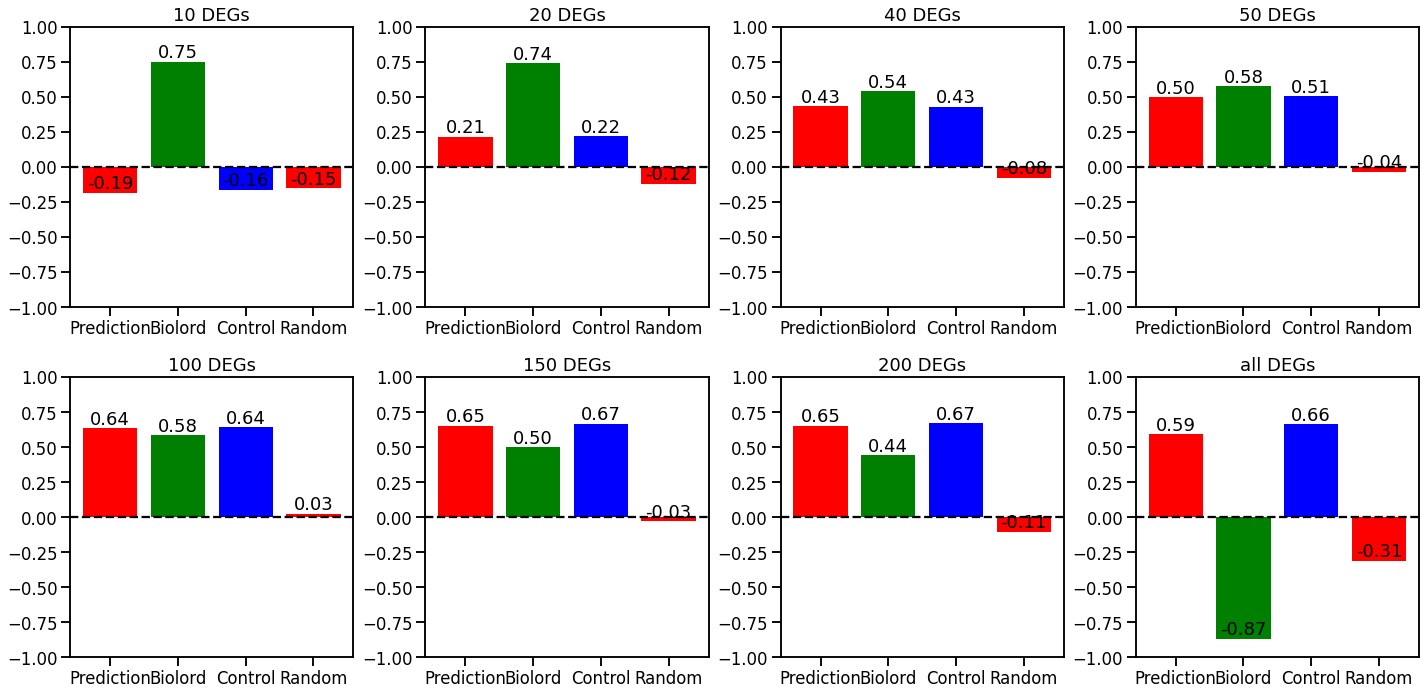

In [ ]:
n_rows = r2_results.shape[0]
df = r2_results
# Plotting each row as a separate bar plot in a 2x4 grid
fig, axes = plt.subplots(nrows=2, ncols=4, figsize=(20, 10))

for i in range(n_rows):
    row = df.iloc[i]  # Extracting the row
    ax = axes[i // 4, i % 4]  # Get the current subplot
    bars = ax.bar(range(len(row)), row, color=['red', 'green', 'blue'])  # Plotting the row values as a bar plot
    ax.axhline(y=0, color='black', linestyle='--')  # Adding a baseline line at y=0
    
    for bar in bars:
        height = bar.get_height()
        ax.text(bar.get_x() + bar.get_width()/2., height,
                '%.2f' % height,
                ha='center', va='bottom')  # Adding value numbers on each bar
    
    ax.set_xticks(range(len(row)))  # Setting x-axis ticks
    ax.set_xticklabels(df.columns)  # Setting x-axis labels
    ax.set_title(f'{r2_results.index[i]} DEGs')  # Setting title
    ax.set_ylim(-1, 1)  # Setting y-axis limit

plt.tight_layout()  # Adjust layout to prevent overlap
plt.show()  # Displaying the plot

In [67]:
n_top_deg = 10
degs = np.where(np.isin(adata.var_names, deg_list[:n_top_deg]))[0]
# x_true[:, degs]

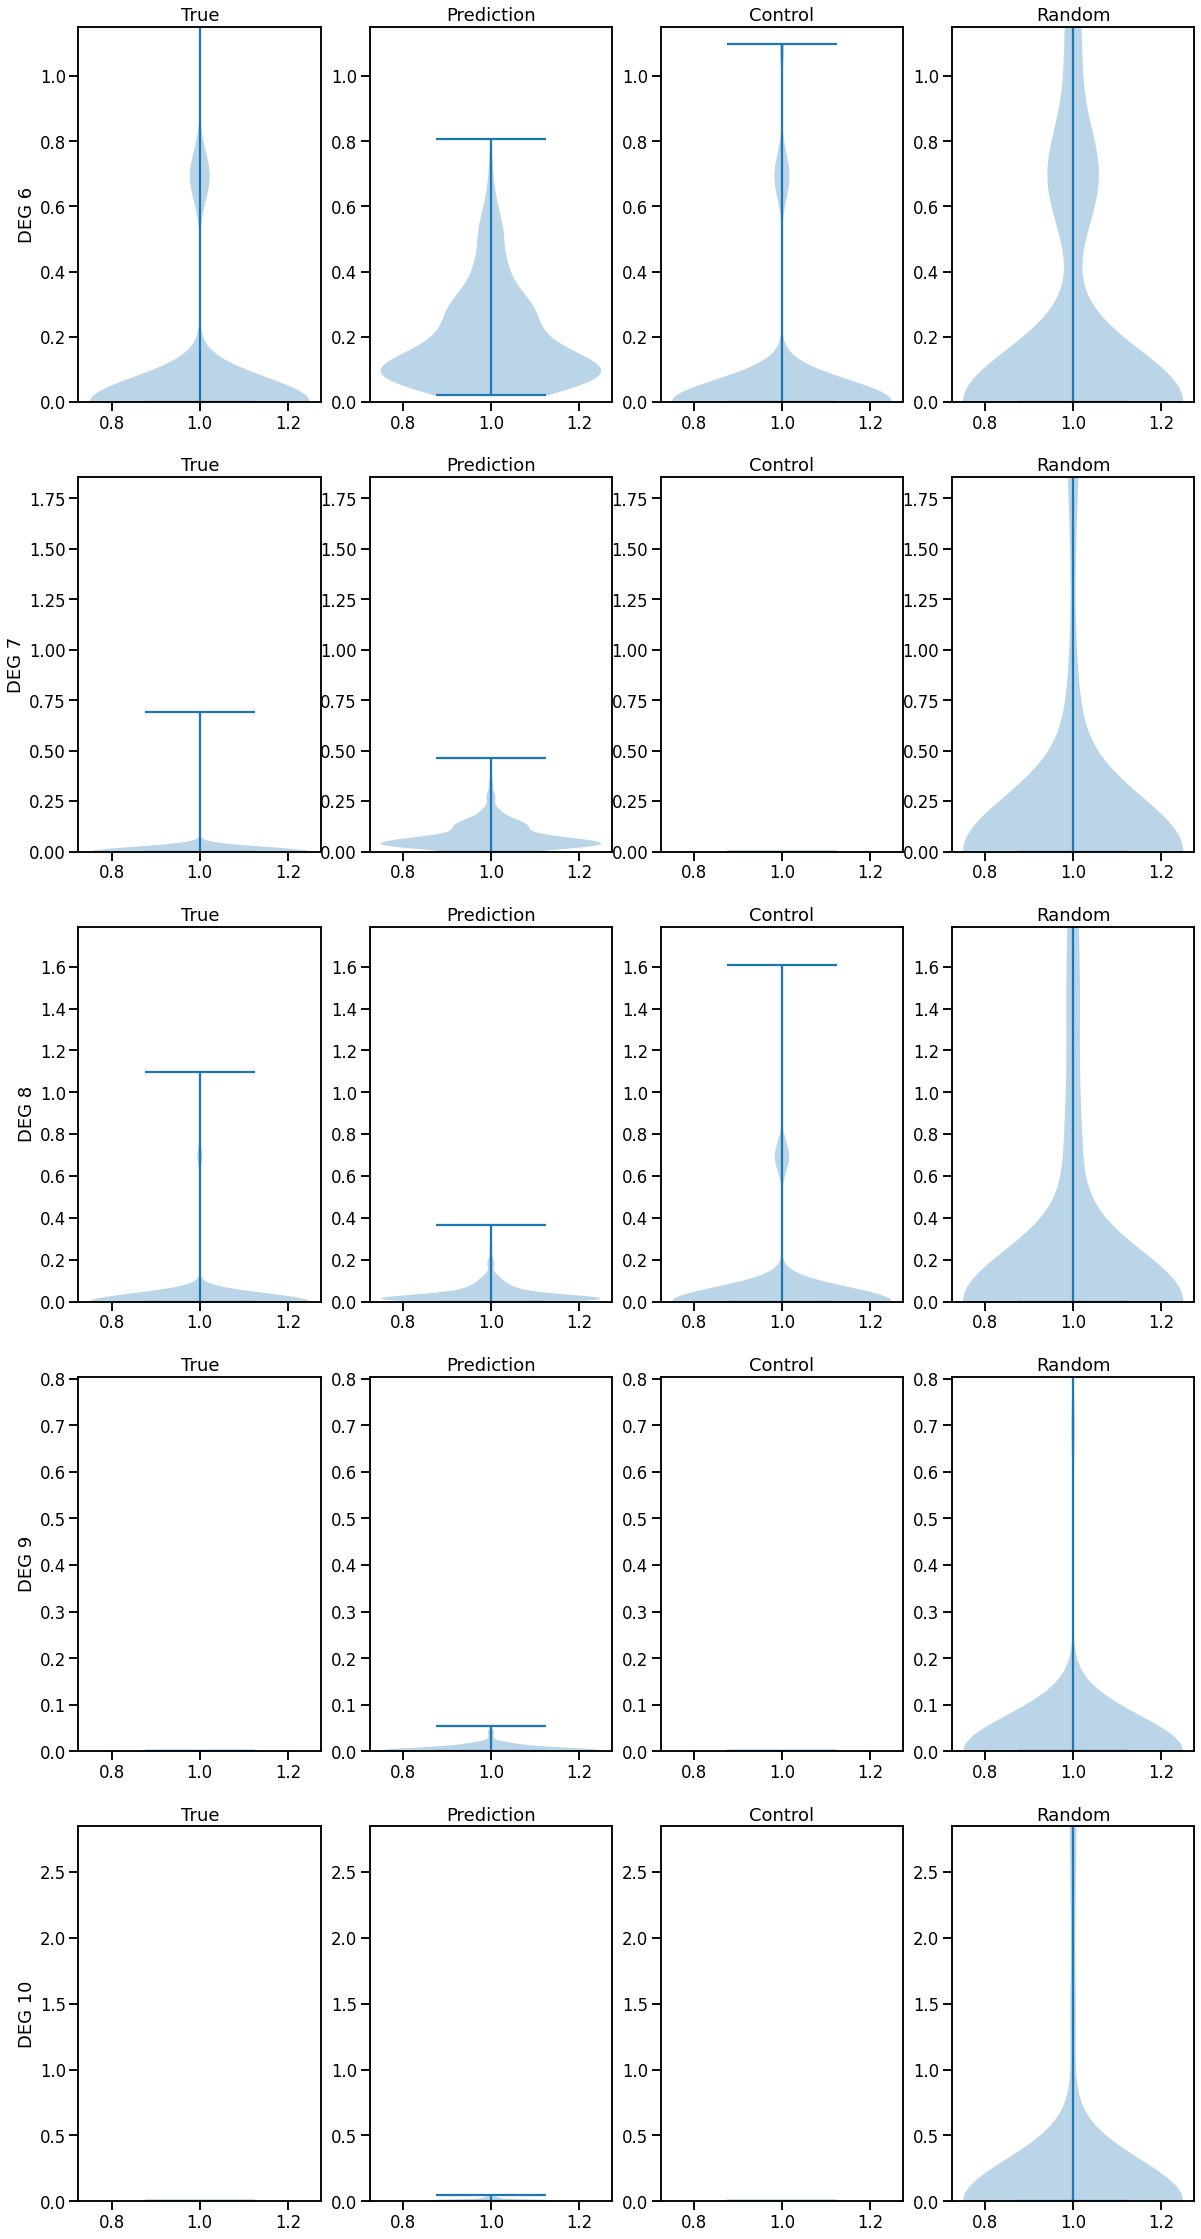

In [70]:
fig, axs = plt.subplots(nrows=len(degs[5:]), ncols=4, figsize=(20, 40))

low = 0
# high = 5
for i, gene in enumerate(degs[5:]):
    high = max(max(x_true[:, gene]), max(x_pred[:, gene]),
               max(x_ctrl[:, gene]), max(x_random[:, gene])) / 2
    
    axs[i][0].violinplot(x_true[:, gene])
    axs[i][0].set_title('True')
    axs[i][0].set_ylim([low, high])
    
    axs[i][1].violinplot(x_pred[:, gene])
    axs[i][1].set_title('Prediction')
    axs[i][1].set_ylim([low, high])

    axs[i][2].violinplot(x_ctrl[:, gene])
    axs[i][2].set_title('Control')
    axs[i][2].set_ylim([low, high])

    axs[i][3].violinplot(x_random[:, gene])
    axs[i][3].set_title('Random')
    axs[i][3].set_ylim([low, high])
    
    # ax.set_xlabel('Four separate samples')
    axs[i][0].set_ylabel(f'DEG {i+6}')
    
    # ax.set_ylim([0,100])
# plt.violinplot(x_random[:, 498])
# plt.ylim(0, 1)
plt.show()